In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.mnist import MNISTDataset

from torch.utils.data import DataLoader
from itertools import product

from scipy.linalg import sqrtm
import ternary

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'mnist_multinomial' in c['name'] 
                    and c['config']['experiment']['batch_size'] == 8]

classy = TinyCNN()
classy.load_state_dict(torch.load('notebooks/mnist_classifier/mnist_tinycnn.pth'))
classy.to('cuda')

# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

def get_generation_composition(samples, classifier, set_size=100):
    preds = classifier(samples.reshape(-1, 1, 28, 28)).argmax(dim=1).reshape(-1, set_size)
    compositions = torch.stack([(set_preds.bincount(minlength=10)) for set_preds in preds])
    return compositions

In [4]:
def compute_latent_interps(cfg, mixed_sets, mix_probs_labels, classy):
    # yay compute time! :)
    results = []
    ids = torch.tensor([1, 4])
    start_prob, end_prob = mix_probs_labels[ids]
    start, end = mixed_sets[ids]

    for c in cfg:
        enc, gen = load_model(c['config'], c['dir'], 'cuda')
        label = c['encoder']

        latent_start = enc(start.reshape(1, 1000, 1, 28, 28))
        latent_end = enc(end.reshape(1, 1000, 1, 28, 28))

        if label == 'WormholeEncoder':
            latent_start = enc(start[:100].unsqueeze(0))
            latent_end = enc(end[:100].unsqueeze(0))

        t = torch.linspace(0, 1, steps=10).cuda()
        points = latent_start * (1 - t).unsqueeze(1) + latent_end * t.unsqueeze(1)

        samples = gen.sample(points, num_samples=1000)
        if label == 'WormholeEncoder':
            samples = samples.repeat(1, 10, 1)
        comp = get_generation_composition(samples, classy, set_size=samples.shape[1])
        interps = [tuple(x.cpu().numpy()[:3].tolist()) for x in comp]

        results.append((label, interps))

    return results, ids
# example usage:


k = 3
points_per_dim = 3
set_size=1000

mix_probs_labels = simplex_grid(k, points_per_dim)
n_sets = len(mix_probs_labels)
mix_probs = torch.tensor(np.repeat(mix_probs_labels, n_sets//k, axis=1))

dataset = MNISTDataset(n_classes=k, n_sets=n_sets, set_size=5000)
mixer = SetMixer(k=k, mixed_set_size=set_size, n_mixed_sets=n_sets)
mixed_sets = mixer.prescribed_mixing(dataset.data.flatten(start_dim=2), mix_probs)
mixed_sets = mixed_sets.to(torch.float).to('cuda')

results, ids = compute_latent_interps(cfg, 
                                      mixed_sets, 
                                      mix_probs, classy)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [5]:
def plot_latent_paths(results, mix_probs_labels, ids, colors, scale=99):
    # now let's draw! :)
    figure, tax = ternary.figure(scale=scale)
    figure.set_size_inches(4, 4)
    figure.set_dpi(200)
    tax.gridlines(color="blue", multiple=11)
    tax.get_axes().axis('off')

    for i, (label, interps) in enumerate(results):
        tax.plot(interps, marker='o', linewidth=2, label=label, color=colors[i % len(colors)])

    tax.scatter((99*mix_probs_labels[ids]).astype(int),
                marker='*', color="#46308d", zorder=10, s=100)
    tax.legend(fontsize=8, loc=(.75, 1))
    tax.show()


/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


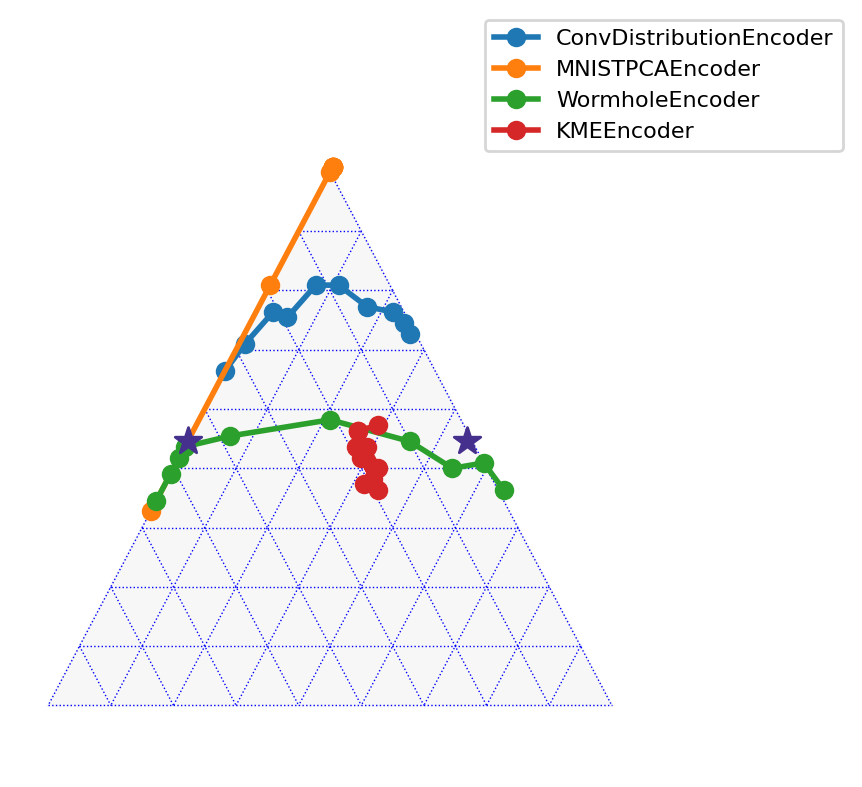

In [9]:
plot_latent_paths([tuple([res[0], [tuple([r//10 for r in t]) for t in res[1]]]) for res in results],
                  mix_probs_labels, ids, sns.color_palette('tab10'))

In [ ]:
enc, gen = load_model(cfg[2]['config'], cfg[2]['dir'], 'cuda')

In [ ]:
gen.sample(enc(start.unsqueeze(0)), num_samples=1000).repeat(1, 10, 1).shape

torch.Size([1, 1000, 784])